# چالش سلامت پلتفرم
mohammadhossein.malekpour@gmail.com

# Table of Contents
- [Setup Environment](#1)
- [Load and Read Data](#2)
- [Data Preprocessing and EDA](#3)
    * [Extract Messages](#3.1)
    * [Post Title WordCloud](#3.2)
    * [Post Categories](#3.3)
    * [Normalize Texts](#3.4)
    * [Word Tokenize](#3.5)
    * [Swear Extraction](#3.6)
    * [Remove Stopwords](#3.7)
    * [Stemming & Lemmatization](#3.8)
    * [Check #Words Distribution](#3.9)
    * [Choosing Initial features](#3.10)
    * [Split Data](#3.11)
    * [TF-IDF Vectorizer](#3.12)
    * [Feature Selection with Chi-Squared](#3.13)
- [Model Data](#4)
    * [Machine Learning Algorithm Selection and Initialization](#4.1)
    * [Tune Model with Hyper-Parameters](#4.2)
    * [Final Model and Competition Submission](#4.3)

<a id="1"></a> 
# Setup Environment

In [1]:
# load packages

import json
import os
import pickle
import re
import statistics
import string
import warnings

import hazm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn import (discriminant_analysis, ensemble, gaussian_process,
                     linear_model, model_selection, naive_bayes, neighbors,
                     neural_network, svm, tree)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, ShuffleSplit,
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder
from wordcloud import STOPWORDS
from wordcloud_fa import WordCloudFa
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

<a id="2"></a> 
# Load and Read Data

In [2]:
raw_data = pd.read_parquet('data/train.parquet',engine='pyarrow') 
test_data = pd.read_parquet('data/test_for_submission.parquet',engine='pyarrow') # for competition submission

persian_swear_data = json.load(open('data.json', encoding="utf8")) # Persian swear words (https://github.com/amirshnll/Persian-Swear-Words)

# however passing by reference is convenient, because we can clean both datasets at once.
data_cleaner = [raw_data, test_data]

In [3]:
# Print a concise summary of a DataFrame

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102568 entries, 2044 to 81632
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   messages                 102568 non-null  object
 1   post_data                102568 non-null  object
 2   reviewed_person_id       102568 non-null  int64 
 3   buyer_id                 102568 non-null  int64 
 4   seller_id                102568 non-null  int64 
 5   post_token               102568 non-null  int64 
 6   unique_conversation_id   102568 non-null  int64 
 7   is_reported              102568 non-null  int32 
 8   reported_at              14452 non-null   object
 9   report_reason            14450 non-null   object
 10  review_date_time         102568 non-null  object
 11  conversation_started_at  102568 non-null  object
 12  review_tag_text          102568 non-null  object
 13  label                    102568 non-null  bool  
dtypes: bool(1), int32(

In [4]:
raw_data.head(2)

,messages,post_data,reviewed_person_id,buyer_id,seller_id,post_token,unique_conversation_id,is_reported,reported_at,report_reason,review_date_time,conversation_started_at,review_tag_text,label
2044,"[{""buyer_or_seller"": ""buyer"", ""message_content...","{""category"": ""health-beauty"", ""title"": ""\u06a9...",888019,888019,867024,331700,4,0,None,None,2020-12-14T04:20:15.461Z,2020-12-13T19:31:33.291Z,NOT_SPAM,False
67053,"[{""buyer_or_seller"": ""buyer"", ""message_content...","{""category"": ""parts-and-accessories"", ""title"":...",338772,282013,338772,644076,11,0,None,None,2020-12-06T06:09:29.731Z,2020-12-05T12:42:21.215Z,IMMORAL,True


<a id="3"></a> 
# Data Preprocessing and EDA

In [5]:
# Load JSON columns

for data in data_cleaner:
    data['messages'] = data['messages'].apply(json.loads)
    data['post_data'] = data['post_data'].apply(json.loads)

In [6]:
# convert 'conversation_started_at' to hour

raw_data['conversation_started_at'] = pd.to_datetime(raw_data.conversation_started_at).dt.hour

In [7]:
# Add post_data content to features

post_data_df = pd.json_normalize(raw_data.post_data).add_prefix('post_')
raw_data = pd.concat([raw_data, post_data_df], axis=1)

post_data_df = pd.json_normalize(test_data.post_data).add_prefix('post_')
test_data = pd.concat([test_data, post_data_df], axis=1)

data_cleaner = [raw_data, test_data]

<a id="3.1"></a> 
## Extract Messages

In [8]:
# identify who is annoying in 'annoying_person' column

for data in data_cleaner:
    data.loc[data.reviewed_person_id == data.buyer_id, 'annoying_person'] = 'buyer'
    data.loc[data.reviewed_person_id == data.seller_id, 'annoying_person'] = 'seller'

In [9]:
# extract annoying person and annoyed person messages

def extract_messages(row, who):
    msg = []        
    for chat in row.messages:
        if who == 'annoying':
            if chat['buyer_or_seller'] == row.annoying_person and chat['message_type'] == 1:
                msg.append(chat['message_content'])
        elif who == 'annoyed':
            if chat['buyer_or_seller'] != row.annoying_person and chat['message_type'] == 1:
                msg.append(chat['message_content'])
    return ' '.join(msg)


for data in data_cleaner:
    data['annoying_person_messages'] = data.apply(extract_messages, args=(['annoying']), axis=1)
    data['annoyed_person_messages'] = data.apply(extract_messages, args=(['annoyed']), axis=1)

<a id="3.2"></a> 
## Post Title WordCloud

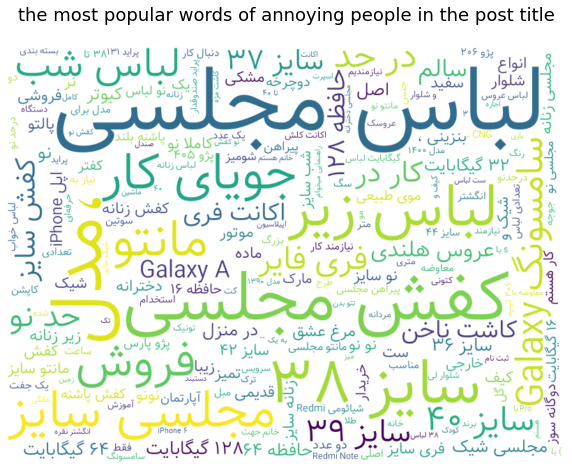

In [10]:
# Post title WordCloud (lable == True)

tmp_df = raw_data.post_title[raw_data.label == True]
words = ' '.join(tmp_df)
wordcloud = WordCloudFa(persian_normalize=True, background_color='white', width=800, height=600)
frequencies = wordcloud.process_text(words)
wc = wordcloud.generate_from_frequencies(frequencies)
image = wc.to_image()
image.save('title_wordcloud.png')

plt.figure(figsize=[10, 10])
plt.imshow(image, interpolation='bilinear')
plt.axis('off')
plt.title('the most popular words of annoying people in the post title\n', fontsize=18)
plt.show()

<a id="3.3"></a> 
## Post Categories

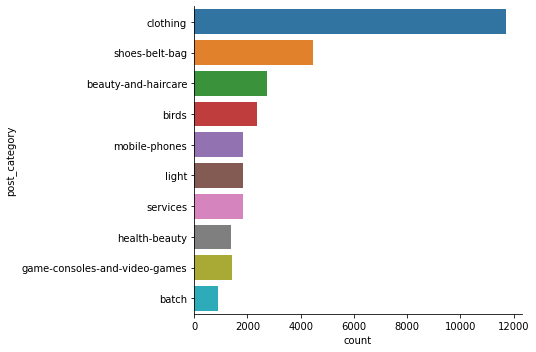

In [11]:
sns.catplot(y='post_category', kind="count", data=raw_data[raw_data.label==True],
            order=raw_data.post_category.value_counts().iloc[:10].index, aspect=1.5)

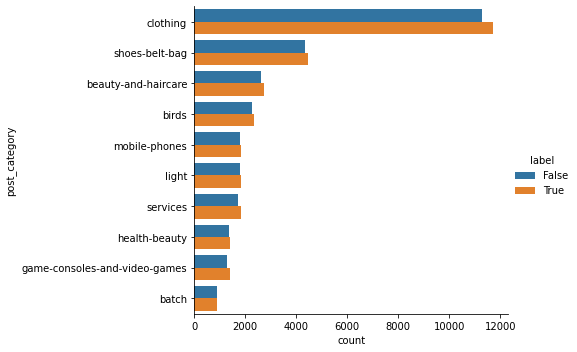

In [12]:
sns.catplot(y='post_category', kind="count", hue='label', data=raw_data,
            order=raw_data.post_category.value_counts().iloc[:10].index, aspect=1.5)

In [13]:
# Encode categorical features (post_category) as a one-hot numeric array

# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(raw_data['post_category'].to_numpy().reshape(-1, 1))
# post_cat = enc.categories_[0].tolist()
# raw_data = pd.concat([raw_data, pd.DataFrame(enc.transform(raw_data['post_category'].to_numpy().reshape(-1, 1)).toarray(), columns=post_cat)], axis=1)
# test_data = pd.concat([test_data, pd.DataFrame(enc.transform(test_data['post_category'].to_numpy().reshape(-1, 1)).toarray(), columns=post_cat)], axis=1)

<a id="3.4"></a> 
## Normalize Texts

In [14]:
# clean and normalize all text

persian_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = persian_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def normalize_persian(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ي", "ی", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ی", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ك" ,"ک" , text)
    text = re.sub("[^ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی]", " ", text)
    text = re.sub("[^\S\n\t]+", ' ', text)
    return text


for data in data_cleaner:
    for col in ['annoying_person_messages', 'annoyed_person_messages', 'post_title', 'post_description']:
        data[col] = data[col].apply(remove_diacritics)
        data[col] = data[col].apply(remove_punctuations)
        data[col] = data[col].apply(normalize_persian)

<a id="3.5"></a> 
## Word Tokenize

In [15]:
# Word Tokenize

for data in data_cleaner:
    for col in ['annoying_person_messages', 'annoyed_person_messages', 'post_title', 'post_description']:
        data[col] = data[col].apply(lambda txt: txt.split())

<a id="3.6"></a> 
## Swear Extraction

In [16]:
# specify annoying person messages have swear or not

def check_swear(row):
    for swear in persian_swear_data['word']:
        if swear in row['annoying_person_messages']:
            return 1
    return 0


for data in data_cleaner:
    data['has_swear'] = data.apply(check_swear, axis=1)

In [17]:
(len(raw_data.loc[(raw_data.has_swear == 1) & (raw_data.label == True)]) / len(raw_data.loc[raw_data.label == True]))

0.2988737312688271

<div dir="rtl">
حدود 30% چت هایی که لیبل مزاحمت خوردنده اند شامل حداقل یک فحش هستند.
<div>

<a id="3.7"></a> 
## Remove Stopwords

In [18]:
# remove stopwords

stopwords = hazm.stopwords_list()

def remove_stopwords(tokens):
    for token in tokens:
        if token in stopwords:
            tokens.remove(token)
    return tokens


for data in data_cleaner:
    for col in ['annoying_person_messages', 'annoyed_person_messages', 'post_title', 'post_description']:
        data[col] = data[col].apply(remove_stopwords)

<a id="3.8"></a> 
## Stemming & Lemmatization

In [19]:
# stemming & lemmatization

def stemming(tokens):
    stemmer = hazm.Stemmer()
    s_tokens = set()
    for token in tokens:
        s_tokens.add(stemmer.stem(token))
    return list(s_tokens)
    
def lemmatization(tokens):
    lemmatizer = hazm.Lemmatizer()
    l_tokens = set()
    for token in tokens:
        l_tokens.add(lemmatizer.lemmatize(token))
    return list(l_tokens)


for data in data_cleaner:
    for col in ['annoying_person_messages', 'annoyed_person_messages', 'post_title', 'post_description']:
        data[col] = data[col].apply(stemming)
        # data[col] = data[col].apply(lemmatization)

<a id="3.9"></a> 
## Check #Words Distribution

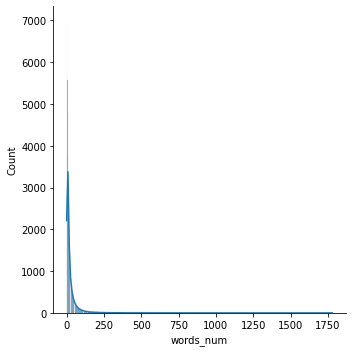

In [20]:
# check distribution of number of words in annoying person messages

def num_words(words):
    return len(words)

def all_words(data):
    words = set()
    for text in data.description_fa:
        for word in text:
            words.add(word)
    return words


for data in data_cleaner:
    data['words_num'] = data.apply(lambda row: num_words(row['annoying_person_messages']), axis=1)
    
sns.displot(raw_data.words_num, kde=True)

<a id="3.10"></a> 
## Choosing Initile Features

In [21]:
# Check all feature and null values

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102568 entries, 0 to 102567
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   messages                   102568 non-null  object 
 1   post_data                  102568 non-null  object 
 2   reviewed_person_id         102568 non-null  int64  
 3   buyer_id                   102568 non-null  int64  
 4   seller_id                  102568 non-null  int64  
 5   post_token                 102568 non-null  int64  
 6   unique_conversation_id     102568 non-null  int64  
 7   is_reported                102568 non-null  int32  
 8   reported_at                14452 non-null   object 
 9   report_reason              14450 non-null   object 
 10  review_date_time           102568 non-null  object 
 11  conversation_started_at    102568 non-null  int64  
 12  review_tag_text            102568 non-null  object 
 13  label                      10

In [22]:
# Keep relevant featuers (drop useless features)

relevant_features = [
    'annoying_person_messages', 'annoyed_person_messages', 'post_title', 'post_description',
    'is_reported', 'post_category', 'conversation_started_at', 'post_category', 'post_num_images',
    'post_contact.chat_enabled', 'annoying_person', 'has_swear', 'words_num', 'label'
]

<AxesSubplot:>

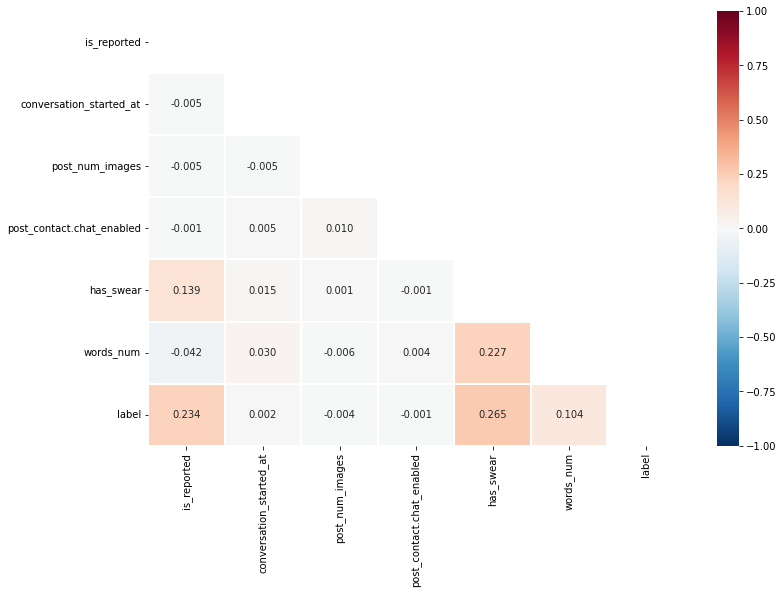

In [23]:
# Checking correlation heatmap show which variables are correlated

df = raw_data[relevant_features]
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".3f", vmin=-1, vmax=1, linewidth = 1, center=0, mask=mask, cmap='RdBu_r')

<div dir="rtl">
همانطورکه ملاحظه میکنید ستون is_reported و has_swear با label کورلیشن دارند.
</div

In [24]:
# cast list of tokens to string

for column in ['annoying_person_messages', 'annoyed_person_messages', 'post_title', 'post_description']:
    raw_data[column] = raw_data[column].apply(lambda x: np.str_(x))
    test_data[column] = test_data[column].apply(lambda x: np.str_(x))

In [25]:
# drop rows that reviewed person no sent any messages!

raw_data.drop(raw_data[raw_data.annoying_person_messages == '[]'].index, inplace=True)

In [26]:
fianl_features = ['annoying_person_messages', 'annoyed_person_messages', 'post_title', 'post_description', 'has_swear', 'is_reported']

<a id="3.11"></a> 
## Split Data

In [27]:
X = raw_data[fianl_features]
y = raw_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

<a id="3.12"></a> 
## TF-IDF Vectorizer

In [28]:
# Vectorize all text features

vectors = dict()
for col in ['annoying_person_messages', 'annoyed_person_messages', 'post_title', 'post_description']:
    tfidfVectorizer = TfidfVectorizer()
    tfidfVectorizer.fit(X_train[col])

    # Splited Data
    vectors['X_train_vector_'+str(col)] = tfidfVectorizer.transform(X_train[col])
    vectors['X_test_vector_'+str(col)] = tfidfVectorizer.transform(X_test[col])

    # Competition Data
    vectors['test_vector_'+str(col)] = tfidfVectorizer.transform(test_data[col])

<a id="3.13"></a> 
## Feature Selection with Chi-Squared

In [29]:
print('Dimension before CHI-2:')
print('X_train_vector_annoying_person_messages', vectors['X_train_vector_annoying_person_messages'].shape)
print('X_train_vector_annoyed_person_messages ', vectors['X_train_vector_annoyed_person_messages'].shape)
print('X_train_vector_post_title              ', vectors['X_train_vector_post_title'].shape)
print('X_train_vector_post_description        ', vectors['X_train_vector_post_description'].shape)

Dimension before CHI-2:
X_train_vector_annoying_person_messages (89284, 111190)
X_train_vector_annoyed_person_messages  (89284, 96880)
X_train_vector_post_title               (89284, 16892)
X_train_vector_post_description         (89284, 69817)


In [30]:
# 'annoying_person_messages' CHI-2 Feature Extraction

transformer_annoying = SelectKBest(chi2, k = 20000).fit(vectors['X_train_vector_annoying_person_messages'], y_train)

# Splited Data
X_train_vector_annoying_best = transformer_annoying.transform(vectors['X_train_vector_annoying_person_messages'])
X_test_vector_annoying_best = transformer_annoying.transform(vectors['X_test_vector_annoying_person_messages'])

# Competition Data
test_vector_annoying_best = transformer_annoying.transform(vectors['test_vector_annoying_person_messages'])

In [31]:
# 'annoyed_person_messages' CHI-2 Feature Extraction

transformer_annoyed = SelectKBest(chi2, k = 10000).fit(vectors['X_train_vector_annoyed_person_messages'], y_train)

# Splited Data
X_train_vector_annoyed_best = transformer_annoyed.transform(vectors['X_train_vector_annoyed_person_messages'])
X_test_vector_annoyed_best = transformer_annoyed.transform(vectors['X_test_vector_annoyed_person_messages'])

# Competition Data
test_vector_annoyed_best = transformer_annoyed.transform(vectors['test_vector_annoyed_person_messages'])

In [32]:
# 'post_title' CHI-2 Feature Extraction

transformer_title = SelectKBest(chi2, k = 500).fit(vectors['X_train_vector_post_title'], y_train)

# Splited Data
X_train_vector_title_best = transformer_title.transform(vectors['X_train_vector_post_title'])
X_test_vector_title_best = transformer_title.transform(vectors['X_test_vector_post_title'])

# Competition Data
test_vector_title_best = transformer_title.transform(vectors['test_vector_post_title'])

In [33]:
# 'post_description' CHI-2 Feature Extraction

transformer_description = SelectKBest(chi2, k = 200).fit(vectors['X_train_vector_post_description'], y_train)

# Splited Data
X_train_vector_description_best = transformer_description.transform(vectors['X_train_vector_post_description'])
X_test_vector_description_best = transformer_description.transform(vectors['X_test_vector_post_description'])

# Competition Data
test_vector_description_best = transformer_description.transform(vectors['test_vector_post_description'])

In [34]:
print('Dimension after CHI-2:')
print('X_train_vector_annoying_best   ', X_train_vector_annoying_best.shape)
print('X_train_vector_annoyed_best    ', X_train_vector_annoyed_best.shape)
print('X_train_vector_title_best      ', X_train_vector_title_best.shape)
print('X_train_vector_description_best', X_train_vector_description_best.shape)

Dimension after CHI-2:
X_train_vector_annoying_best    (89284, 20000)
X_train_vector_annoyed_best     (89284, 10000)
X_train_vector_title_best       (89284, 500)
X_train_vector_description_best (89284, 200)


In [35]:
# Stack all extracted features together

# Splited Data
new_X_train_features = scipy.sparse.csr_matrix(X_train[['has_swear', 'is_reported']].values)
new_X_test_features = scipy.sparse.csr_matrix(X_test[['has_swear', 'is_reported']].values)

X_train_vector_best = scipy.sparse.hstack((X_train_vector_annoying_best,
                                           X_train_vector_annoyed_best,
                                           X_train_vector_title_best,
                                           X_train_vector_description_best,
                                           new_X_train_features))

X_test_vector_best = scipy.sparse.hstack((X_test_vector_annoying_best,
                                          X_test_vector_annoyed_best,
                                          X_test_vector_title_best,
                                          X_test_vector_description_best,
                                          new_X_test_features))


# Competition Data
new_test_features = scipy.sparse.csr_matrix(test_data[['has_swear', 'is_reported']].values)
test_vector_best = scipy.sparse.hstack((test_vector_annoying_best,
                                        test_vector_annoyed_best,
                                        test_vector_title_best,
                                        test_vector_description_best,
                                        new_test_features))

In [36]:
print('Final Dimension:')
print('X_train_vector_best', X_train_vector_best.shape)
print('X_test_vector_best ', X_test_vector_best.shape)

Final Dimension:
X_train_vector_best (89284, 30702)
X_test_vector_best  (9921, 30702)


<a id="4"></a> 
# Model Data

Running this section may take hours. Continue with **"Competition Submission"** SubSection to Learn final model.

<a id="4.1"></a> 
## Machine Learning Algorithm Selection and Initialization

In [37]:
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.RandomForestClassifier(), 
    ensemble.ExtraTreesClassifier(), 
    
    # Linear Models
    linear_model.PassiveAggressiveClassifier(), 
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    linear_model.LogisticRegression(),
    
    # Neural Network
    # neural_network.MLPClassifier(),
    
    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.MultinomialNB(),
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # SVM
    # svm.SVC(probability=True),
    
    # Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # Gradient boosting tree
    XGBClassifier(eval_metric='mlogloss')
    ]

In [38]:
# Initialization with X_train_vector_best data (37502 feature)

# split dataset in cross-validation with this splitter class
cv_split = model_selection.ShuffleSplit(n_splits=5, test_size=.1, train_size =.8, random_state=0) # run model 5x with 80/10 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test ROC Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = {}

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    print(MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # Score model with cross validation
    cv_results = model_selection.cross_validate(alg, X_train_vector_best, y_train, cv  = cv_split,scoring='roc_auc', return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test ROC Accuracy Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3  

    row_index+=1
    
# Print and sort table
MLA_compare.sort_values(by = ['MLA Test ROC Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

AdaBoostClassifier
BaggingClassifier
RandomForestClassifier
ExtraTreesClassifier
PassiveAggressiveClassifier
SGDClassifier
Perceptron
LogisticRegression
BernoulliNB
MultinomialNB
KNeighborsClassifier
DecisionTreeClassifier
ExtraTreeClassifier
XGBClassifier


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test ROC Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
7,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.937108,0.912721,0.00262451,1.95441
9,MultinomialNB,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.923974,0.906406,0.0077516,0.0481992
5,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.918745,0.904851,0.00384588,0.275797
3,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.999914,0.893985,0.00681539,816.263
2,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.999658,0.890009,0.00886945,476.27
4,PassiveAggressiveClassifier,"{'C': 1.0, 'average': False, 'class_weight': N...",0.968277,0.887852,0.0143718,1.12201
13,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.921137,0.882983,0.0088656,25.7326
6,Perceptron,"{'alpha': 0.0001, 'class_weight': None, 'early...",0.950479,0.871529,0.0221399,0.444197
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.998133,0.844656,0.00947547,738.903
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.827987,0.825466,0.014059,78.4025


Text(0, 0.5, 'Algorithm')

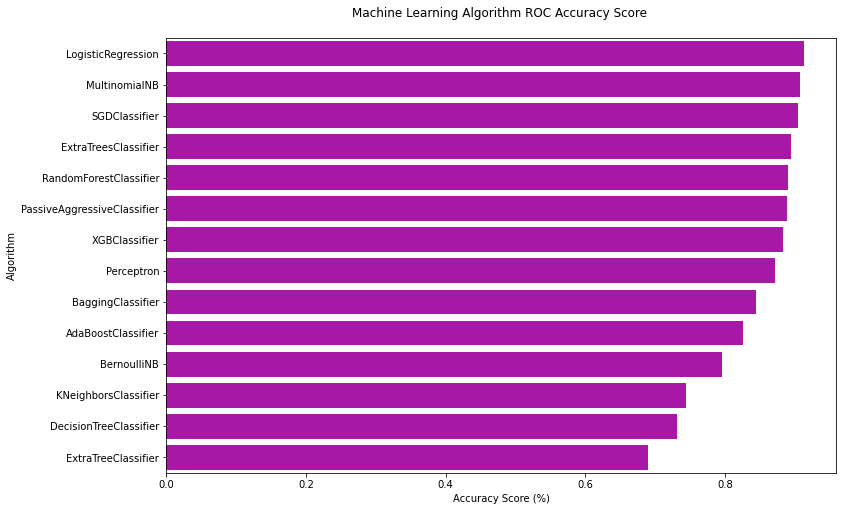

In [39]:
plt.figure(figsize = (12, 8))
sns.barplot(x='MLA Test ROC Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')
plt.title('Machine Learning Algorithm ROC Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

<a id="4.2"></a> 
## LogisticRegression: Tune Model with Hyper-Parameters

In [40]:
# base model

cv_split = model_selection.ShuffleSplit(n_splits=5, test_size =.1, train_size =.8, random_state=0) # run model 5x with 80/10 split intentionally leaving out 10%
model = linear_model.LogisticRegression()
base_results = model_selection.cross_validate(model, X_train_vector_best, y_train, cv=cv_split, scoring='roc_auc', return_train_score=True)
model.fit(X_train_vector_best, y_train)

print('BEFORE Parameters: ', model.get_params())
print("BEFORE train score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("AFTER test ROC score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE test score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

param_grid = {
    'C' : [3, 2.5, 2, 1.5, 1.0, 0.5],
    'max_iter': [300],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'tol': [0.01, 0.001, 0.0001, 0.00001]
}

# tune model
tune_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=cv_split, return_train_score=True)
tune_model.fit(X_train_vector_best, y_train)


print('AFTER Parameters: ', tune_model.best_params_)
print("AFTER train score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER test ROC score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER test score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE Parameters:  {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
BEFORE train score mean: 93.71
AFTER test ROC score mean: 91.27
BEFORE test score 3*std: +/- 0.26
----------
AFTER Parameters:  {'C': 3, 'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-05}
AFTER train score mean: 95.28
AFTER test ROC score mean: 91.65
AFTER test score 3*std: +/- 0.21
----------


<a id="4.3"></a> 
## Final Model and Competition Submission

learn final model less than 5 second & predict competiition dataset:

In [41]:
final_model = linear_model.LogisticRegression(C=3, max_iter=300, penalty='l2', solver='liblinear', tol=0.00001)
final_model.fit(X_train_vector_best, y_train)

prediction = final_model.predict(X_test_vector_best)
print(classification_report(y_test, prediction))

print('ROC Accuracy: ', roc_auc_score(y_test, final_model.predict_proba(X_test_vector_best)[:,1]), '%')

              precision    recall  f1-score   support

       False       0.82      0.86      0.84      4898
        True       0.86      0.82      0.84      5023

    accuracy                           0.84      9921
   macro avg       0.84      0.84      0.84      9921
weighted avg       0.84      0.84      0.84      9921

ROC Accuracy:  0.9128107073326317 %


In [43]:
test_prediction_prabaility = final_model.predict_proba(test_vector_best)[:,1]
pd.DataFrame(data={'unique_conversation_id': test_data.unique_conversation_id ,'predictions': test_prediction_prabaility}).to_csv('prediction.csv', index=False)

<br><br><br><br>Please let me know if there’s anything I can provide to assist you in your decision-making process.

Thank you :)